In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import itertools

import tokenize_uk
from stop_words import get_stop_words

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.utils import resample

from common import *

In [12]:
df = pd.read_json('reviews.json')

In [13]:
for n, g in df.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 4676
Class: 4 length: 15051
Class: 5 length: 42405


#### Preprocessing data 
- join paragraphs
- lowercase everything 

In [14]:
df['text'] = df['text'].apply(lambda x: ' '.join(x).lower())

In [15]:
df.head(20)

,stars,text
0,5,компьютерная марка lenovo известна своими дост...
1,5,вопрос к представителю:. можно ли надеяться на...
2,5,очень хорошая рабочая шустрая лошадка с приятн...
3,5,сбалансированные характеристики у планшета. дл...
4,5,"чудовий планшет, дружина використовує завжди з..."
5,4,користуюсь більше місяця. звичайно є недоліки...
6,3,планшет покупался для работы с текстами в доро...
7,5,майнкрафт на минимальных настройках графики по...
8,5,adobe p и adobe i как пойдут?
9,3,існують питання до якості картриджа недостатки...


#### Partitioning data into train/validation
Train is later used for cross-validation 

In [16]:
X, y = df['text'].values, df['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

for cls in np.sort(np.unique(y)):
    print('Train Class {}: {} examples'.format(cls, len(y[y == cls])))
    print('Validation Class {}: {} examples'.format(cls, len(y_val[y_val == cls])))
    
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

Train Class 1: 1844 examples
Validation Class 1: 461 examples
Train Class 2: 1843 examples
Validation Class 2: 461 examples
Train Class 3: 3741 examples
Validation Class 3: 935 examples
Train Class 4: 12041 examples
Validation Class 4: 3010 examples
Train Class 5: 33923 examples
Validation Class 5: 8482 examples


#### Creating learning pipeline with RandomForestClassifier and BOW without any text preprocessing

In [17]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9863348362163407
Train score:  0.9860136804640774
Train score:  0.9857571467944978
Test CV score: 0.5741012342602527
Validation score: 0.5791700082577242


#### Confusion matrix for RF with BOW

[[  46   13   29  105  268]
 [  25   16   42  138  240]
 [  26   15   63  320  511]
 [  20   18  102  828 2042]
 [  25   22   87  930 7418]]


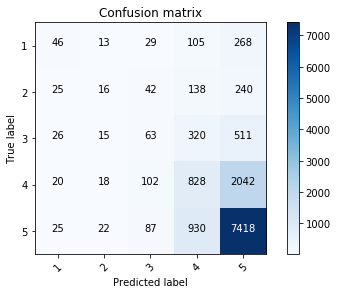

In [9]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [10]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.32      0.10      0.15       461
          2       0.19      0.03      0.06       461
          3       0.20      0.07      0.10       935
          4       0.36      0.28      0.31      3010
          5       0.71      0.87      0.78      8482

avg / total       0.56      0.63      0.58     13349



As we can see from above reports, due to imbalanced classes (42k in 5th class vs 2k in 1th and 2nd classes), 
majority class is predicted with f1_score = 0.78, whereas f1_score for 1st and 2nd classes eq 0.11 and 0.08 respectively.

#### Creating learning pipeline with RandomForestClassifier and TF-IDF without any text preprocessing

In [11]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9863686800901947


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9860894245065137


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9854121660963052
Test CV score: 0.5541749800972161


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Validation score: 0.5589391907708006


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[[  39   17   23   71  311]
 [  25   17   17   81  321]
 [  22   11   34  185  683]
 [  13   10   41  430 2516]
 [  11    7   30  413 8021]]


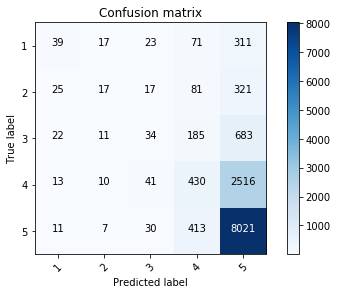

In [12]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [13]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.35      0.08      0.14       461
          2       0.27      0.04      0.07       461
          3       0.23      0.04      0.06       935
          4       0.36      0.14      0.21      3010
          5       0.68      0.95      0.79      8482

avg / total       0.55      0.64      0.56     13349



Similar situation with TF-IDF, so the problem is in fact that classes are imbalanced, not feature extraction method (for now)

### Resampling dataset to make it balanced

Min class is `1` and `2` so downlsampling other to their length

In [14]:
df_minority = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2] # no downsampling here as it is small enough

df_3 = df[df['stars'] == 3]
df_4 = df[df['stars'] == 4]
df_5 = df[df['stars'] == 5]

df_3_downsampled = resample(df_3, replace=False, n_samples=len(df_minority), random_state=1234)
df_4_downsampled = resample(df_4, replace=False, n_samples=len(df_minority), random_state=1234)
df_5_downsampled = resample(df_5, replace=False, n_samples=len(df_minority), random_state=1234)

df_downsampled = pd.concat([df_minority, df_2, df_3_downsampled, df_4_downsampled, df_5_downsampled])

for n, g in df_downsampled.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 2305
Class: 4 length: 2305
Class: 5 length: 2305


In [15]:
X, y = df_downsampled['text'].values, df_downsampled['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

#### Creating RF + BOW pipeline on downsampled data

In [16]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.987303494751918
Train score:  0.9907236704846046
Train score:  0.986984301538252
Test CV score: 0.344362826721434
Validation score: 0.3561125560015682


[[237 104  61  28  31]
 [179 118  91  53  20]
 [ 94 123 129  67  48]
 [ 47  79  94 130 111]
 [ 42  50  55 101 213]]


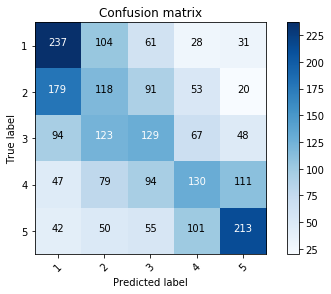

In [17]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [18]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.40      0.51      0.45       461
          2       0.25      0.26      0.25       461
          3       0.30      0.28      0.29       461
          4       0.34      0.28      0.31       461
          5       0.50      0.46      0.48       461

avg / total       0.36      0.36      0.36      2305



Overal validation score dropped drammatically to ~0.35
Although, from confusion matrix that classes 1, 2 (and a bit less 3) are confused between each other very often. 
From classification report we can see that f1_scores/precision/recall became a bit more equally distributed. 

#### RF + TF-IDF on balanced classes

In [19]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9900718288890465


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9918654465835033


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Train score:  0.9908923032353193
Test CV score: 0.32856161296237757


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Validation score: 0.33117612657648504


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[[225 114  52  39  31]
 [164 128  86  56  27]
 [104 125 105  80  47]
 [ 78  58  87 126 112]
 [ 56  35  71 112 187]]


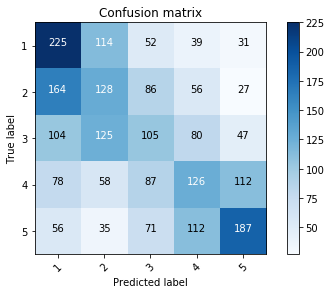

In [20]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [21]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.36      0.49      0.41       461
          2       0.28      0.28      0.28       461
          3       0.26      0.23      0.24       461
          4       0.31      0.27      0.29       461
          5       0.46      0.41      0.43       461

avg / total       0.33      0.33      0.33      2305



Same here. It is obvious now - we need better feature extraction method. First line attack with ignoring language, numbers, stopwords and other didn't work out. 

Further investigations are in separate notebook. 